In [629]:
%reload_ext autoreload
%autoreload 2

# **Model Training**

In [630]:
from Ecommerce_Analytics.utils.paths import data_processed_dir
import Ecommerce_Analytics.plot as plots
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
from datetime import timedelta
import seaborn as sns
import Ecommerce_Analytics.plot as plots
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import MinMaxScaler

## **Forecasting Analysis**

In [631]:
processed_data_path = data_processed_dir("units_sold_per_day.csv")
units_sold_per_day = pd.read_csv(processed_data_path, encoding="utf-8")
units_sold_per_day["sale_date"] = pd.to_datetime(units_sold_per_day["sale_date"])
units_sold_per_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   sale_date                    374 non-null    datetime64[ns]
 1   total_quantity               374 non-null    int64         
 2   total_quantity_rolling_mean  368 non-null    float64       
 3   total_quantity_imputed       374 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 11.8 KB


In [632]:
units_sold_per_day.head()

,sale_date,total_quantity,total_quantity_rolling_mean,total_quantity_imputed
0,2020-12-01,456,NaN,456
1,2020-12-02,171,NaN,171
2,2020-12-03,184,NaN,184
3,2020-12-04,0,NaN,0
4,2020-12-05,175,NaN,175


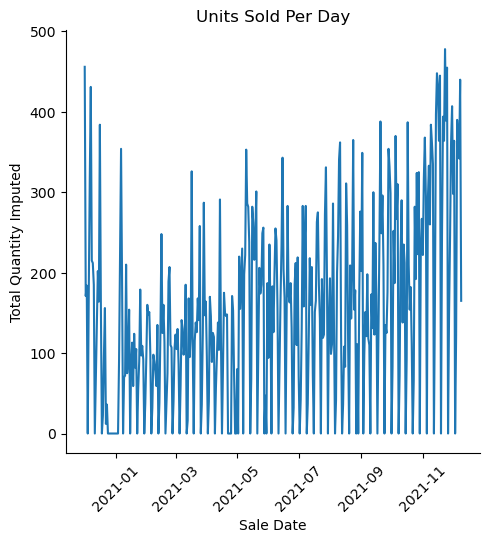

In [633]:
plots.custom_line_plot(df=units_sold_per_day, x_column="sale_date", y_column="total_quantity_imputed", title="Units Sold Per Day")

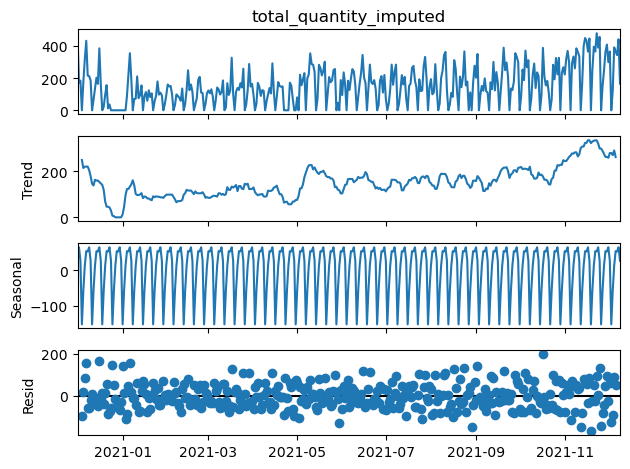

In [634]:
units_sold_per_day.set_index("sale_date", inplace=True)
units_sold_per_day = units_sold_per_day.asfreq("D") 
decomposition_plot_add = seasonal_decompose(units_sold_per_day["total_quantity_imputed"], model="additive")
decomposition_plot_add.plot()
plt.show()

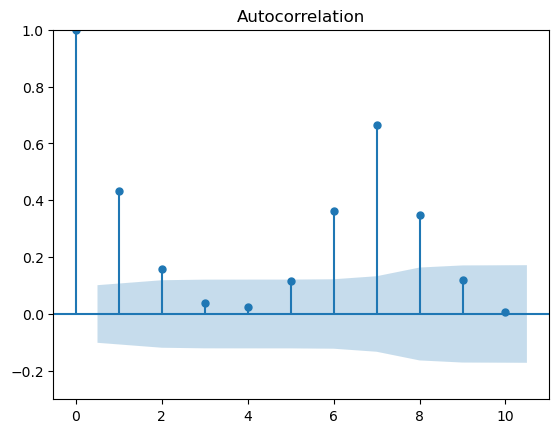

In [635]:
plot_acf(units_sold_per_day["total_quantity_imputed"], lags=10)
plt.ylim(-0.3, 1)
plt.show()

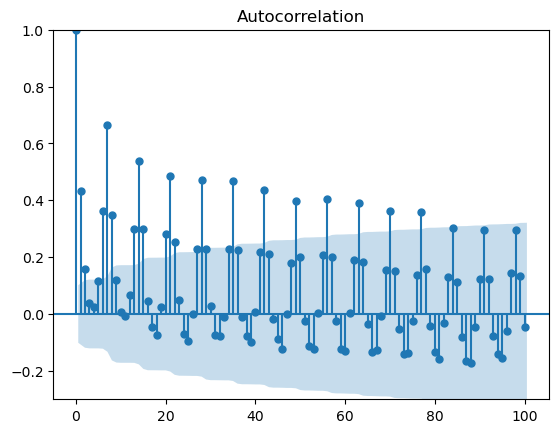

In [636]:
plot_acf(units_sold_per_day["total_quantity_imputed"], lags=100)
plt.ylim(-0.3, 1)
plt.show()

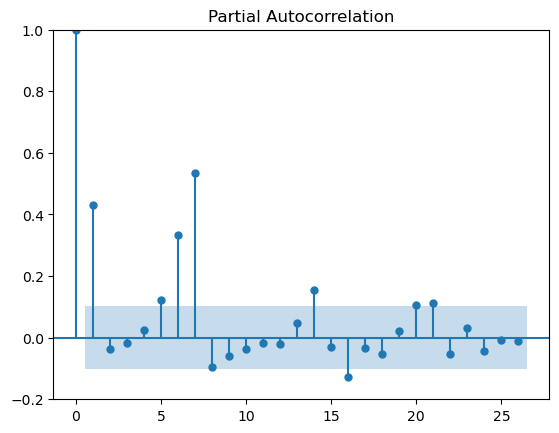

In [637]:
plot_pacf(units_sold_per_day["total_quantity_imputed"], method="ywm")
plt.ylim(-0.2, 1)
plt.show()

In [638]:
units_sold_per_day["total_quantity_imputed_boxcox"], lam = boxcox(units_sold_per_day["total_quantity_imputed"] + 0.01)
units_sold_per_day["total_quantity_imputed_boxcox"] = units_sold_per_day["total_quantity_imputed_boxcox"].diff()
units_sold_per_day.head()

,total_quantity,total_quantity_rolling_mean,total_quantity_imputed,total_quantity_imputed_boxcox
sale_date,,,,
2020-12-01,456,NaN,456,NaN
2020-12-02,171,NaN,171,-8.259643
2020-12-03,184,NaN,184,0.516989
2020-12-04,0,NaN,0,-18.494344
2020-12-05,175,NaN,175,18.138960


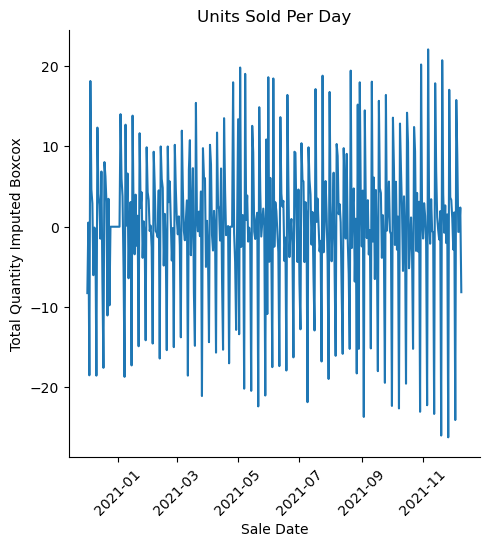

In [639]:
plots.custom_line_plot(df=units_sold_per_day, x_column="sale_date", y_column="total_quantity_imputed_boxcox", title="Units Sold Per Day")

In [640]:
stationarity_test_results = adfuller(units_sold_per_day["total_quantity_imputed_boxcox"][1:])
print(f"ADF Statistic: {stationarity_test_results[0]}")
print(f"P-Value: {stationarity_test_results[1]}")
print('Critical Values:')
for threshold, adf_statistic in stationarity_test_results[4].items():
    print("%s: %.2f" % (threshold, adf_statistic))

ADF Statistic: -8.479734463763418
P-Value: 1.4036935397443398e-13
Critical Values:
1%: -3.45
5%: -2.87
10%: -2.57


In [641]:
units_sold_per_day["total_quantity_rolling_mean"] = units_sold_per_day["total_quantity_rolling_mean"].round(2)
units_sold_per_day["total_quantity_rolling_mean"] = units_sold_per_day["total_quantity_rolling_mean"].bfill()
units_sold_per_day.head()

,total_quantity,total_quantity_rolling_mean,total_quantity_imputed,total_quantity_imputed_boxcox
sale_date,,,,
2020-12-01,456,248.0,456,NaN
2020-12-02,171,248.0,171,-8.259643
2020-12-03,184,248.0,184,0.516989
2020-12-04,0,248.0,0,-18.494344
2020-12-05,175,248.0,175,18.138960


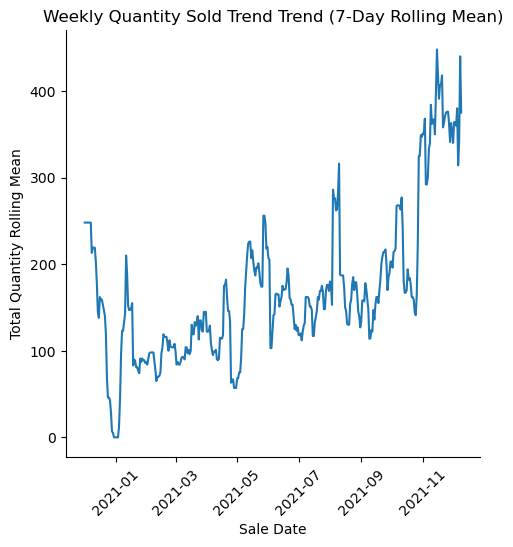

In [642]:
plots.custom_line_plot(df=units_sold_per_day, x_column="sale_date", y_column="total_quantity_rolling_mean", title="Weekly Quantity Sold Trend Trend (7-Day Rolling Mean)")

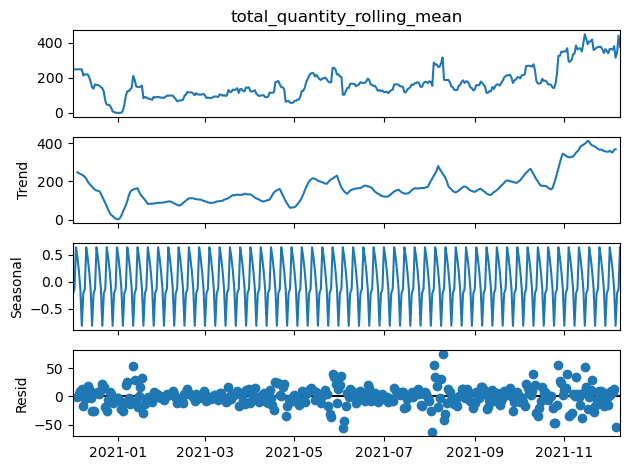

In [643]:
decomposition_plot_add = seasonal_decompose(units_sold_per_day["total_quantity_rolling_mean"], model="additive")
decomposition_plot_add.plot()
plt.show()

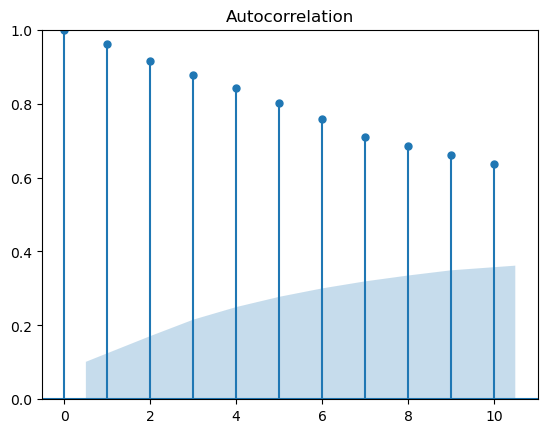

In [644]:
plot_acf(units_sold_per_day["total_quantity_rolling_mean"], lags=10)
plt.ylim(0, 1)
plt.show()

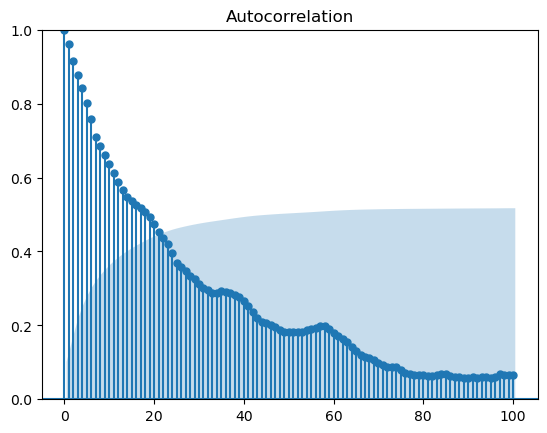

In [645]:
plot_acf(units_sold_per_day["total_quantity_rolling_mean"], lags=100)
plt.ylim(0, 1)
plt.show()

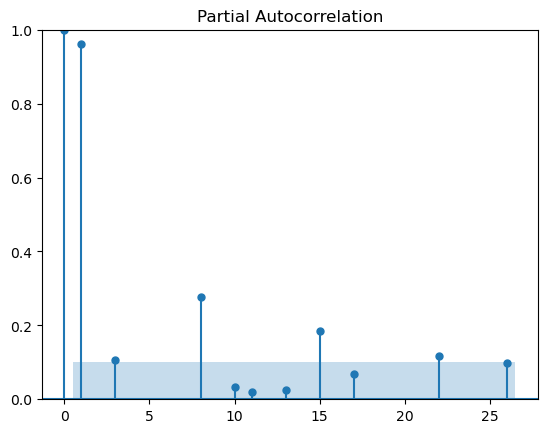

In [646]:
plot_pacf(units_sold_per_day["total_quantity_rolling_mean"], method="ywm")
plt.ylim(0, 1)
plt.show()

In [647]:
units_sold_per_day["total_quantity_rolling_mean_boxcox"], lam = boxcox(units_sold_per_day["total_quantity_rolling_mean"] + 0.01)
units_sold_per_day["total_quantity_rolling_mean_boxcox"] = units_sold_per_day["total_quantity_rolling_mean_boxcox"].diff()
units_sold_per_day.reset_index(inplace=True)
units_sold_per_day.head()

,sale_date,total_quantity,total_quantity_rolling_mean,total_quantity_imputed,total_quantity_imputed_boxcox,total_quantity_rolling_mean_boxcox
0,2020-12-01,456,248.0,456,NaN,NaN
1,2020-12-02,171,248.0,171,-8.259643,0.0
2,2020-12-03,184,248.0,184,0.516989,0.0
3,2020-12-04,0,248.0,0,-18.494344,0.0
4,2020-12-05,175,248.0,175,18.138960,0.0


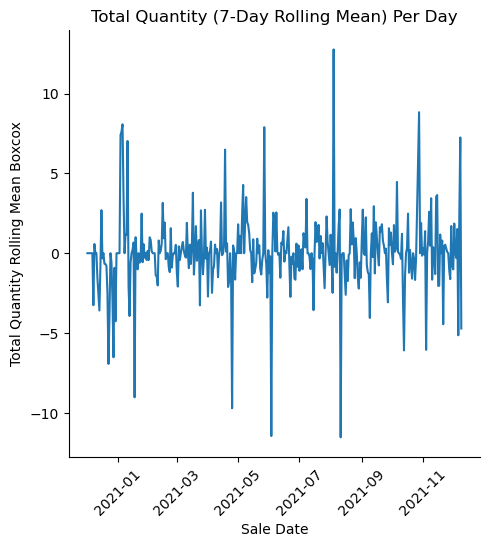

In [648]:
plots.custom_line_plot(df=units_sold_per_day, x_column="sale_date", y_column="total_quantity_rolling_mean_boxcox", title="Total Quantity (7-Day Rolling Mean) Per Day")

In [649]:
stationarity_test_results = adfuller(units_sold_per_day["total_quantity_rolling_mean_boxcox"][1:])
print(f"ADF Statistic: {stationarity_test_results[0]}")
print(f"P-Value: {stationarity_test_results[1]}")
print("Critical Values:")
for threshold, adf_statistic in stationarity_test_results[4].items():
    print("%s: %.2f" % (threshold, adf_statistic))

ADF Statistic: -8.303454342307191
P-Value: 3.9611715518638604e-13
Critical Values:
1%: -3.45
5%: -2.87
10%: -2.57


In [650]:
units_sold_per_day.reset_index(inplace=True)
columns = ["sale_date", "total_quantity_rolling_mean"]
units_sold_per_day = units_sold_per_day[columns]
units_sold_per_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 2 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   sale_date                    374 non-null    datetime64[ns]
 1   total_quantity_rolling_mean  374 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.0 KB


In [651]:
total_rows = len(units_sold_per_day)
limit = -int(total_rows * 0.2)
train_df = units_sold_per_day.iloc[:limit]
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 2 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   sale_date                    300 non-null    datetime64[ns]
 1   total_quantity_rolling_mean  300 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.8 KB


In [652]:
test_df = units_sold_per_day.iloc[limit:]
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 300 to 373
Data columns (total 2 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   sale_date                    74 non-null     datetime64[ns]
 1   total_quantity_rolling_mean  74 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.3 KB


In [653]:
processed_data_path = data_processed_dir("wasp_per_day.csv")
wasp_per_day = pd.read_csv(processed_data_path, encoding="utf-8")
wasp_per_day["sale_date"] = pd.to_datetime(wasp_per_day["sale_date"])
wasp_per_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   sale_date          374 non-null    datetime64[ns]
 1   total_sale         374 non-null    float64       
 2   total_quantity     374 non-null    int64         
 3   wasp               374 non-null    float64       
 4   wasp_rolling_mean  368 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 14.7 KB


In [654]:
wasp_per_day.head()

,sale_date,total_sale,total_quantity,wasp,wasp_rolling_mean
0,2020-12-01,9103.02,456,19.96,NaN
1,2020-12-02,3283.26,171,19.20,NaN
2,2020-12-03,7619.94,184,41.41,NaN
3,2020-12-04,0.00,0,41.41,NaN
4,2020-12-05,3661.74,175,20.92,NaN


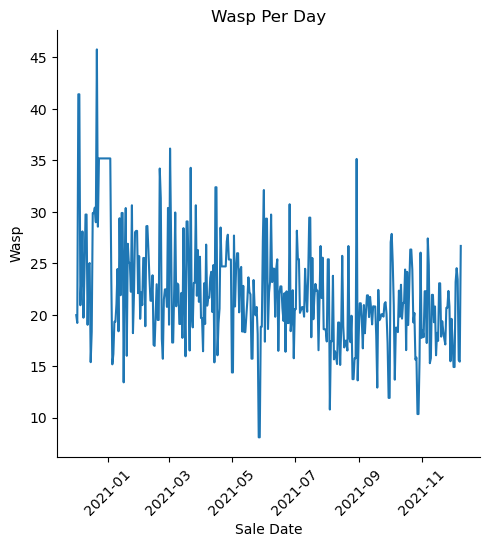

In [655]:
plots.custom_line_plot(df=wasp_per_day, x_column="sale_date", y_column="wasp", title="Wasp Per Day")

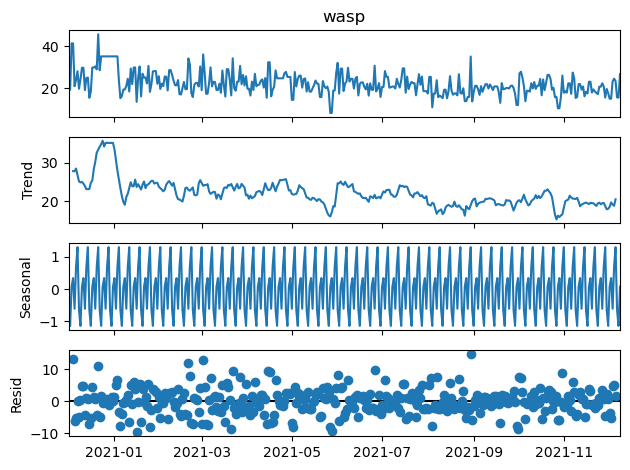

In [656]:
wasp_per_day.set_index("sale_date", inplace=True)
wasp_per_day = wasp_per_day.asfreq("D") 
decomposition_plot_add = seasonal_decompose(wasp_per_day["wasp"], model="additive")
decomposition_plot_add.plot()
plt.show()

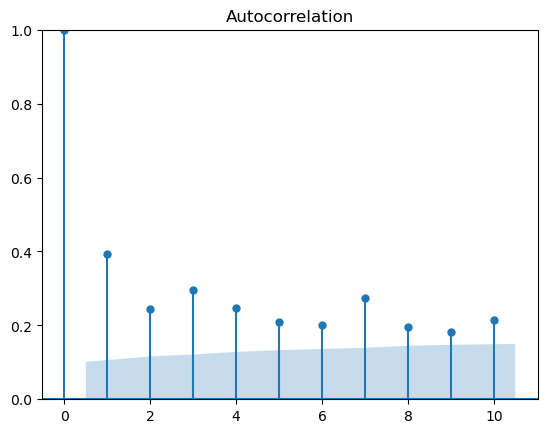

In [657]:
plot_acf(wasp_per_day["wasp"], lags=10)
plt.ylim(0, 1)
plt.show()

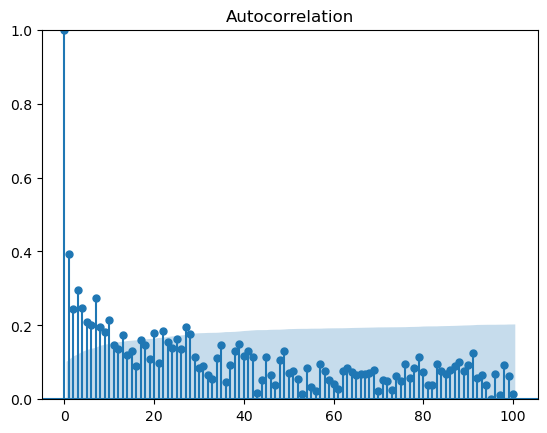

In [658]:
plot_acf(wasp_per_day["wasp"], lags=100)
plt.ylim(0, 1)
plt.show()

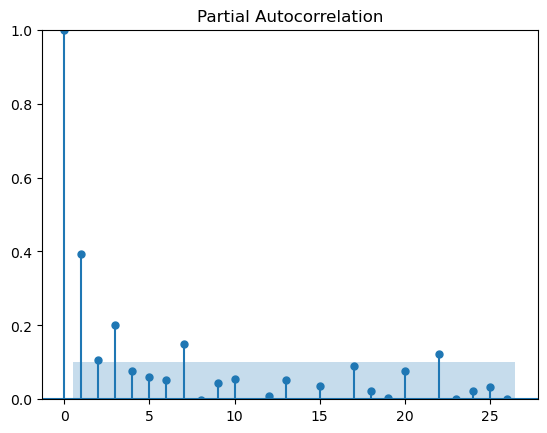

In [659]:
plot_pacf(wasp_per_day["wasp"], method="ywm")
plt.ylim(0, 1)
plt.show()

In [660]:
wasp_per_day["wasp_boxcox"], lam = boxcox(wasp_per_day["wasp"])
wasp_per_day["wasp_boxcox"] = wasp_per_day["wasp_boxcox"].diff()
wasp_per_day.reset_index(inplace=True)
wasp_per_day.head()

,sale_date,total_sale,total_quantity,wasp,wasp_rolling_mean,wasp_boxcox
0,2020-12-01,9103.02,456,19.96,NaN,NaN
1,2020-12-02,3283.26,171,19.20,NaN,-0.066414
2,2020-12-03,7619.94,184,41.41,NaN,1.405616
3,2020-12-04,0.00,0,41.41,NaN,0.000000
4,2020-12-05,3661.74,175,20.92,NaN,-1.258211


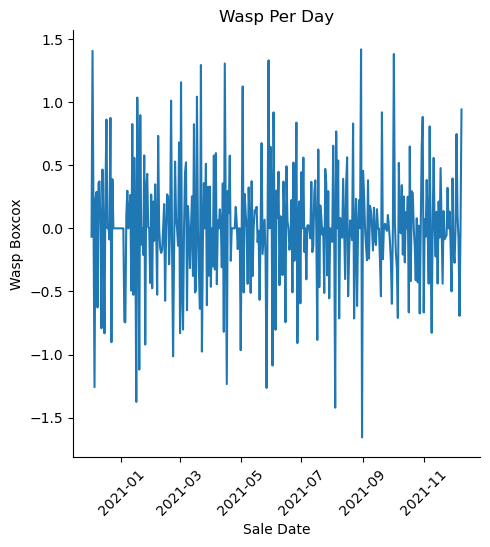

In [661]:
plots.custom_line_plot(df=wasp_per_day, x_column="sale_date", y_column="wasp_boxcox", title="Wasp Per Day")

In [662]:
stationarity_test_results = adfuller(wasp_per_day["wasp_boxcox"][1:])
print(f"ADF Statistic: {stationarity_test_results[0]}")
print(f"P-Value: {stationarity_test_results[1]}")
print("Critical Values:")
for threshold, adf_statistic in stationarity_test_results[4].items():
    print("%s: %.2f" % (threshold, adf_statistic))

ADF Statistic: -10.217526316348398
P-Value: 5.432105751166488e-18
Critical Values:
1%: -3.45
5%: -2.87
10%: -2.57


In [663]:
wasp_per_day["wasp_rolling_mean"] = wasp_per_day["wasp"].rolling(window=7, center=False).mean()
wasp_per_day["wasp_rolling_mean"] = wasp_per_day["wasp_rolling_mean"].round(2)
wasp_per_day["wasp_rolling_mean"] = wasp_per_day["wasp_rolling_mean"].bfill()
wasp_per_day.head()

,sale_date,total_sale,total_quantity,wasp,wasp_rolling_mean,wasp_boxcox
0,2020-12-01,9103.02,456,19.96,27.85,NaN
1,2020-12-02,3283.26,171,19.20,27.85,-0.066414
2,2020-12-03,7619.94,184,41.41,27.85,1.405616
3,2020-12-04,0.00,0,41.41,27.85,0.000000
4,2020-12-05,3661.74,175,20.92,27.85,-1.258211


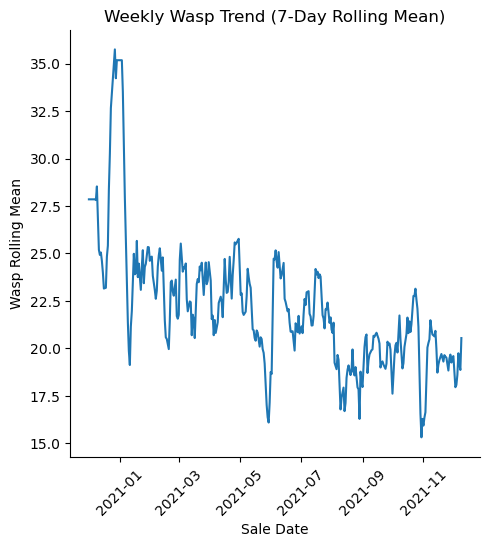

In [664]:
plots.custom_line_plot(df=wasp_per_day, x_column="sale_date", y_column="wasp_rolling_mean", title="Weekly Wasp Trend (7-Day Rolling Mean)")

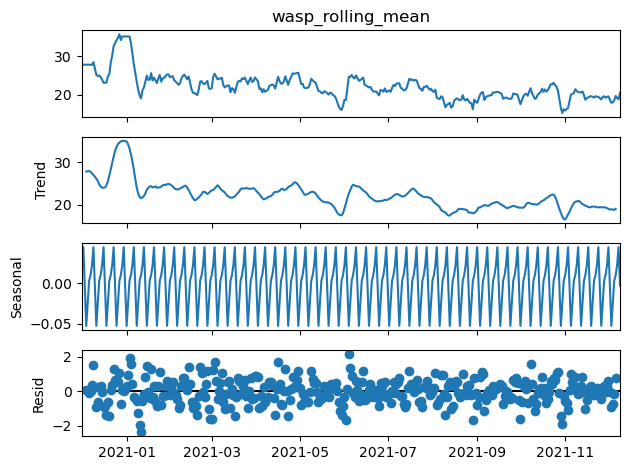

In [665]:
wasp_per_day.set_index("sale_date", inplace=True)
wasp_per_day = wasp_per_day.asfreq("D") 
decomposition_plot_add = seasonal_decompose(wasp_per_day["wasp_rolling_mean"], model="additive")
decomposition_plot_add.plot()
plt.show()

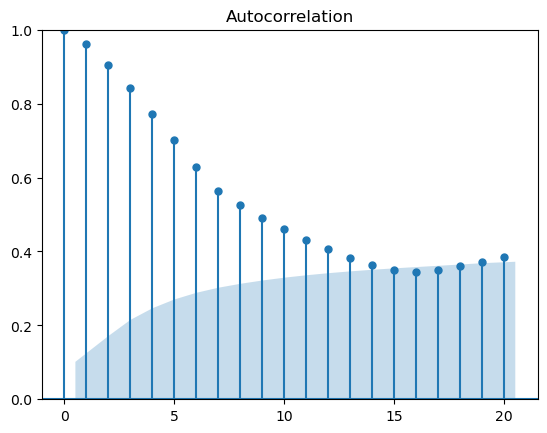

In [666]:
plot_acf(wasp_per_day["wasp_rolling_mean"], lags=20)
plt.ylim(0, 1)
plt.show()

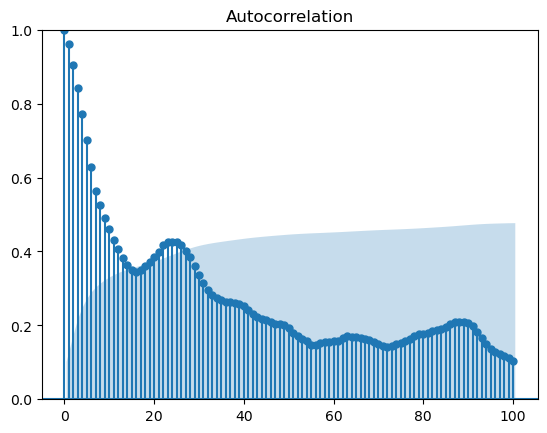

In [667]:
plot_acf(wasp_per_day["wasp_rolling_mean"], lags=100)
plt.ylim(0, 1)
plt.show()

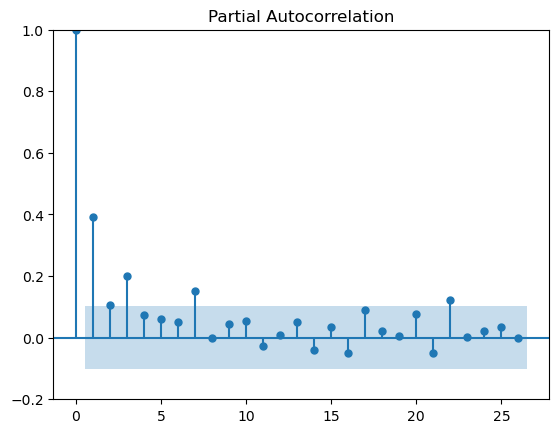

In [668]:
plot_pacf(wasp_per_day["wasp"], method="ywm")
plt.ylim(-0.2, 1)
plt.show()

In [669]:
wasp_per_day["wasp_rolling_mean_boxcox"], lam = boxcox(wasp_per_day["wasp_rolling_mean"])
wasp_per_day["wasp_rolling_mean_boxcox"] = wasp_per_day["wasp_rolling_mean_boxcox"].diff()
wasp_per_day.reset_index(inplace=True)
wasp_per_day.head()

,sale_date,total_sale,total_quantity,wasp,wasp_rolling_mean,wasp_boxcox,wasp_rolling_mean_boxcox
0,2020-12-01,9103.02,456,19.96,27.85,NaN,NaN
1,2020-12-02,3283.26,171,19.20,27.85,-0.066414,0.0
2,2020-12-03,7619.94,184,41.41,27.85,1.405616,0.0
3,2020-12-04,0.00,0,41.41,27.85,0.000000,0.0
4,2020-12-05,3661.74,175,20.92,27.85,-1.258211,0.0


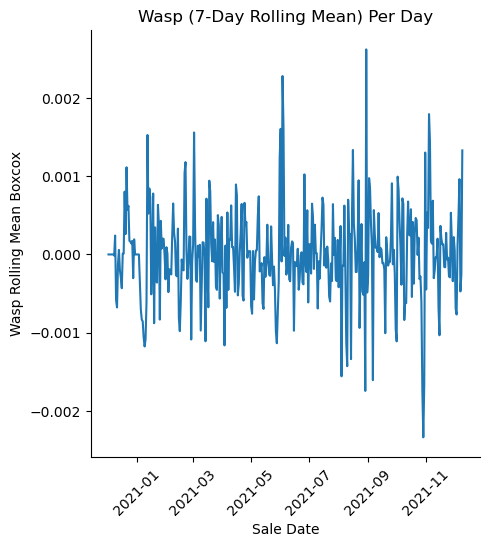

In [670]:
plots.custom_line_plot(df=wasp_per_day, x_column="sale_date", y_column="wasp_rolling_mean_boxcox", title="Wasp (7-Day Rolling Mean) Per Day")

In [671]:
stationarity_test_results = adfuller(wasp_per_day["wasp_rolling_mean_boxcox"][1:])
print(f"ADF Statistic: {stationarity_test_results[0]}")
print(f"P-Value: {stationarity_test_results[1]}")
print("Critical Values:")
for threshold, adf_statistic in stationarity_test_results[4].items():
    print("%s: %.2f" % (threshold, adf_statistic))

ADF Statistic: -7.8221837252247335
P-Value: 6.624939169956573e-12
Critical Values:
1%: -3.45
5%: -2.87
10%: -2.57


## **Clustering Analysis**

In [672]:
processed_sales_path = data_processed_dir("sale.csv")
sales_df = pd.read_csv(processed_sales_path, encoding="utf-8")
sales_df = sales_df[sales_df["customer_id"]!=-1]
sales_df["sale_date"] = pd.to_datetime(sales_df["sale_date"])
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18921 entries, 0 to 23149
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   transaction_date          18921 non-null  object        
 1   customer_id               18921 non-null  int64         
 2   sale_product_description  18921 non-null  object        
 3   stock_code                18921 non-null  int64         
 4   invoice_no                18921 non-null  int64         
 5   quantity                  18921 non-null  int64         
 6   sale                      18921 non-null  float64       
 7   unit_price                18921 non-null  float64       
 8   sale_date                 18921 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(4), object(2)
memory usage: 1.4+ MB


In [673]:
sales_df["total_sale"] = sales_df["quantity"] * sales_df["sale"]
sales_df.head()

,transaction_date,customer_id,sale_product_description,stock_code,invoice_no,quantity,sale,unit_price,sale_date,total_sale
0,2020-12-01 08:26:00,17850,Dog and Puppy Pads,85123,536365,1,15.30,15.30,2020-12-01,15.30
1,2020-12-01 08:34:00,13047,Pet Odor Eliminator,84879,536367,6,60.84,10.14,2020-12-01,365.04
2,2020-12-01 08:34:00,13047,Rechargeable Pet Nail Grinder,22960,536368,1,25.50,25.50,2020-12-01,25.50
3,2020-12-01 09:02:00,17850,Dog and Puppy Pads,85123,536373,1,15.30,15.30,2020-12-01,15.30
4,2020-12-01 09:32:00,15291,ChomChom Pet Hair Remover - Reusable Cat and D...,22114,536376,8,165.60,20.70,2020-12-01,1324.80


In [674]:
snapshot_date = sales_df["sale_date"].max() + timedelta(days=1)

rfm_df = sales_df.groupby("customer_id", as_index=False).agg({
    "sale_date": lambda date: (snapshot_date - date.max()).days,
    "invoice_no": "nunique",
    "total_sale": "sum"
})

rfm_df.rename(columns={"sale_date":"recency","invoice_no":"frequency","total_sale":"monetary_value"}, inplace=True)

rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3084 entries, 0 to 3083
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   customer_id     3084 non-null   int64  
 1   recency         3084 non-null   int64  
 2   frequency       3084 non-null   int64  
 3   monetary_value  3084 non-null   float64
dtypes: float64(1), int64(3)
memory usage: 96.5 KB


In [675]:
rfm_df.head()

,customer_id,recency,frequency,monetary_value
0,12347,3,6,1215.12
1,12349,19,1,131.70
2,12352,73,3,242.10
3,12354,233,1,39.60
4,12355,215,1,76.50


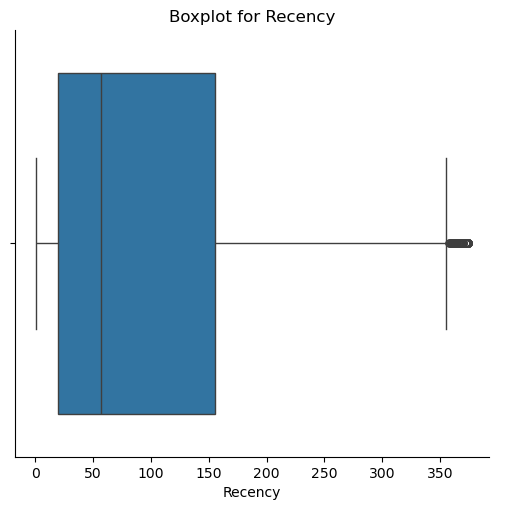

In [676]:
plots.custom_box_plot(df=rfm_df, x_column="recency")

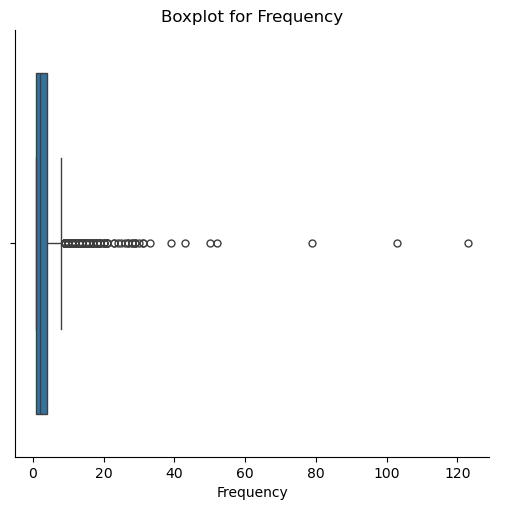

In [677]:
plots.custom_box_plot(df=rfm_df, x_column="frequency")

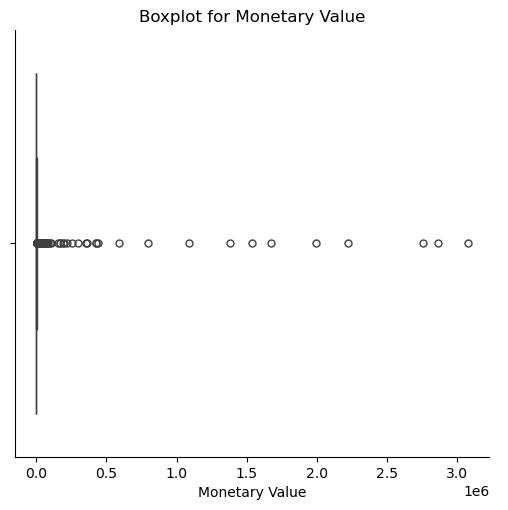

In [678]:
plots.custom_box_plot(df=rfm_df, x_column="monetary_value")

In [679]:
rfm_df["recency_log"] = np.log(rfm_df["recency"])
rfm_df["frequency_log"] = np.log(rfm_df["frequency"])
rfm_df["monetary_value_log"] = np.log(rfm_df["monetary_value"])
rfm_df.head()

,customer_id,recency,frequency,monetary_value,recency_log,frequency_log,monetary_value_log
0,12347,3,6,1215.12,1.098612,1.791759,7.102598
1,12349,19,1,131.70,2.944439,0.000000,4.880527
2,12352,73,3,242.10,4.290459,1.098612,5.489351
3,12354,233,1,39.60,5.451038,0.000000,3.678829
4,12355,215,1,76.50,5.370638,0.000000,4.337291


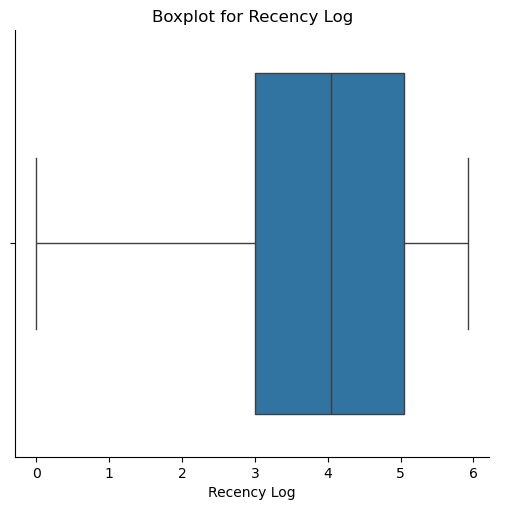

In [680]:
plots.custom_box_plot(df=rfm_df, x_column="recency_log")

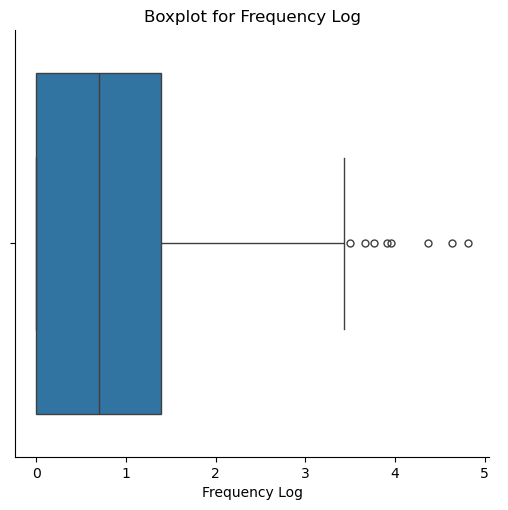

In [681]:
plots.custom_box_plot(df=rfm_df, x_column="frequency_log")

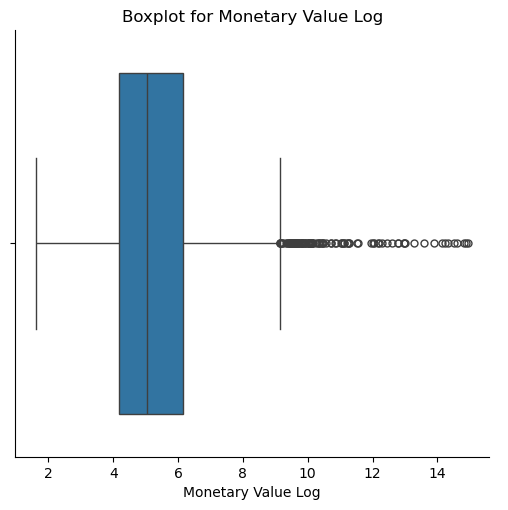

In [682]:
plots.custom_box_plot(df=rfm_df, x_column="monetary_value_log")

In [683]:
rfm_df["recency_boxcox"], lamda_recency = boxcox(rfm_df["recency"])
rfm_df["frequency_boxcox"], lamda_frequency = boxcox(rfm_df["frequency"])
rfm_df["monetary_value_boxcox"], lamda_monetary = boxcox(rfm_df["monetary_value"])
rfm_df.head()

,customer_id,recency,frequency,monetary_value,recency_log,frequency_log,monetary_value_log,recency_boxcox,frequency_boxcox,monetary_value_boxcox
0,12347,3,6,1215.12,1.098612,1.791759,7.102598,1.213492,1.124395,3.864577
1,12349,19,1,131.70,2.944439,0.000000,4.880527,3.871465,0.000000,3.160557
2,12352,73,3,242.10,4.290459,1.098612,5.489351,6.441698,0.817333,3.384373
3,12354,233,1,39.60,5.451038,0.000000,3.678829,9.210526,0.000000,2.633520
4,12355,215,1,76.50,5.370638,0.000000,4.337291,8.999714,0.000000,2.937381


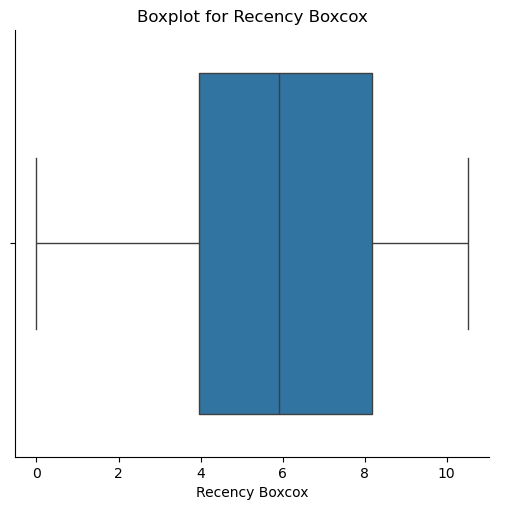

In [684]:
plots.custom_box_plot(df=rfm_df, x_column="recency_boxcox")

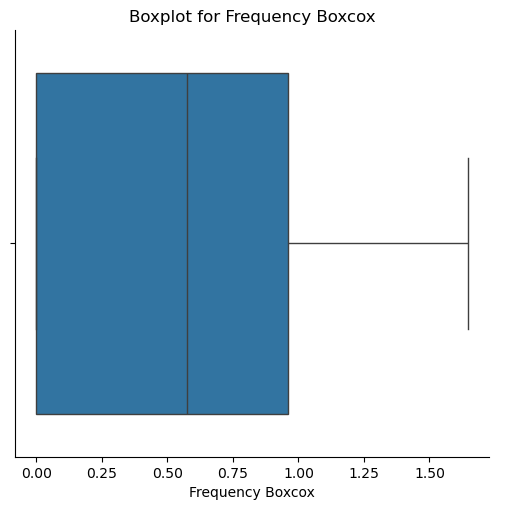

In [685]:
plots.custom_box_plot(df=rfm_df, x_column="frequency_boxcox")

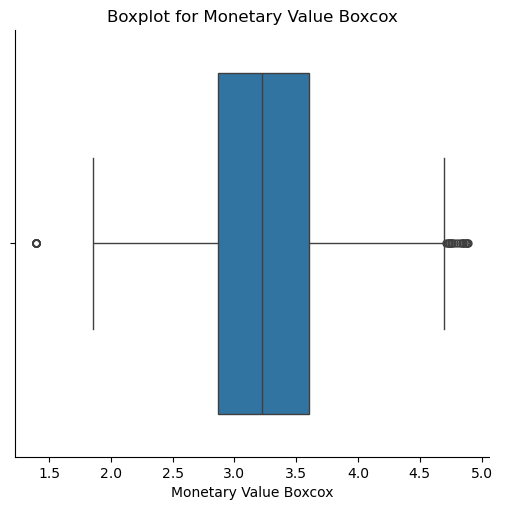

In [686]:
plots.custom_box_plot(df=rfm_df, x_column="monetary_value_boxcox")

In [687]:
columns = ["recency_boxcox", "frequency_boxcox", "monetary_value_boxcox"]
rfm_to_scale = rfm_df[columns]

rfm_scaler = StandardScaler()
rfm_scaled = rfm_scaler.fit_transform(rfm_to_scale)
rfm_scaled = pd.DataFrame(rfm_scaled, index=rfm_df.index, columns=rfm_to_scale.columns)
rfm_scaled.head()

,recency_boxcox,frequency_boxcox,monetary_value_boxcox
0,-1.822110,1.280868,1.120057
1,-0.797885,-1.072106,-0.111881
2,0.192529,0.638292,0.279767
3,1.259470,-1.072106,-1.034125
4,1.178236,-1.072106,-0.502409


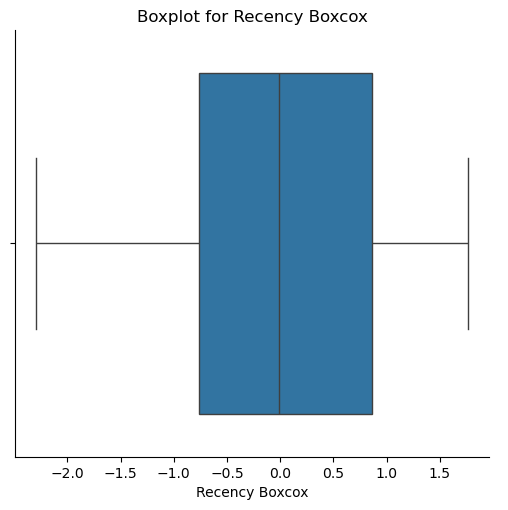

In [688]:
plots.custom_box_plot(df=rfm_scaled, x_column="recency_boxcox")

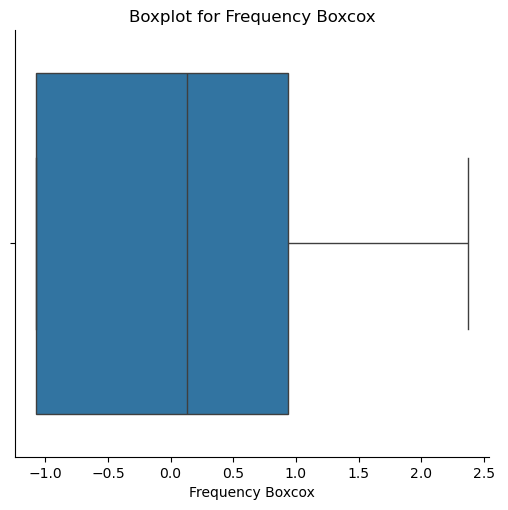

In [689]:
plots.custom_box_plot(df=rfm_scaled, x_column="frequency_boxcox")

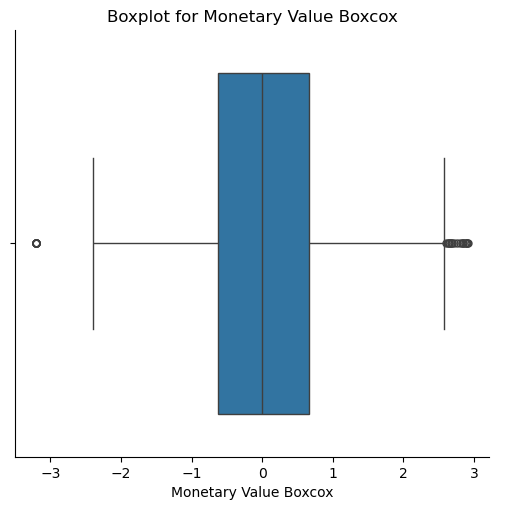

In [690]:
plots.custom_box_plot(df=rfm_scaled, x_column="monetary_value_boxcox")

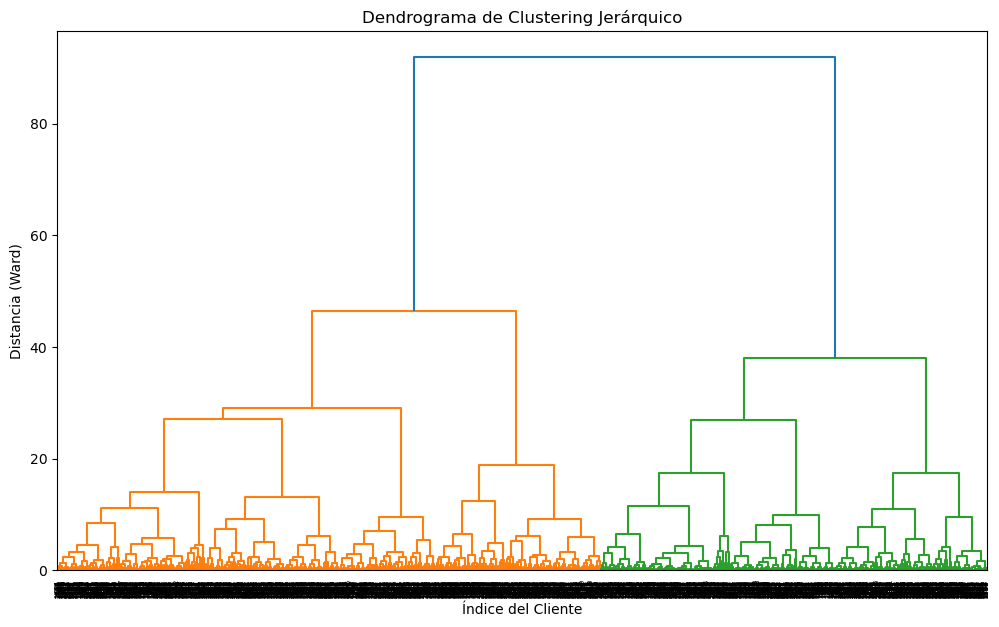

In [691]:
linked = linkage(rfm_scaled, method="ward")
plt.figure(figsize=(12, 7))
dendrogram(linked, orientation="top", distance_sort="descending", show_leaf_counts=True)
plt.title("Dendrograma de Clustering Jerárquico")
plt.xlabel("Índice del Cliente")
plt.ylabel("Distancia (Ward)")
plt.show()

### **Agglomerative Clustering**

In [692]:
k_hierarchical = 3
agg_cluster = AgglomerativeClustering(n_clusters=k_hierarchical, linkage="ward")
rfm_df["agg_cluster"] = agg_cluster.fit_predict(rfm_scaled)
agg_summary = rfm_df.groupby("agg_cluster", as_index=False).agg({"recency":"mean","frequency": "mean","monetary_value": "mean", "customer_id":"count"}).round(2)
agg_summary.rename(columns={"customer_id": "n_customers"}, inplace=True)
agg_summary.head()

,agg_cluster,recency,frequency,monetary_value,n_customers
0,0,151.30,1.00,2658.00,1279
1,1,79.86,3.16,5329.00,1253
2,2,12.95,8.72,31486.31,552


### **KMeans Clustering**

In [693]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans.fit(rfm_scaled)
rfm_df["km_cluster"] = kmeans.labels_
km_summary = rfm_df.groupby("km_cluster", as_index=False).agg({"recency":"mean","frequency": "mean","monetary_value": "mean", "customer_id":"count"}).round(2)
km_summary.rename(columns={"customer_id": "n_customers"}, inplace=True)
km_summary.head()

,km_cluster,recency,frequency,monetary_value,n_customers
0,0,98.23,2.62,7139.49,964
1,1,17.60,7.07,23139.21,885
2,2,154.21,1.03,78.22,1235


### **DBSCAN Clustering**

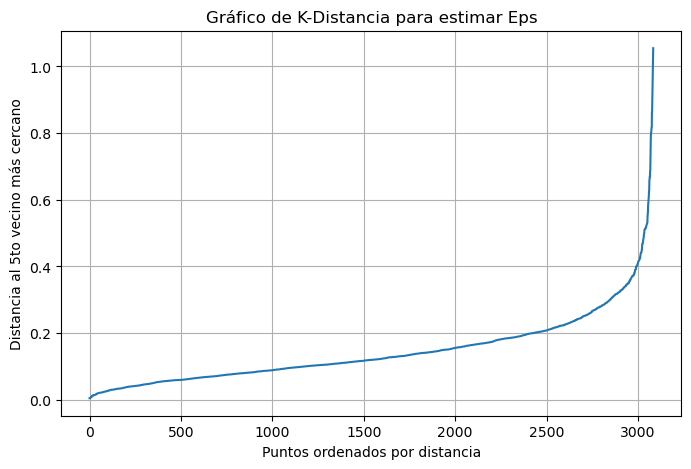

In [694]:
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(rfm_scaled)
distances, indices = nbrs.kneighbors(rfm_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:,4]
plt.figure(figsize=(8,5))
plt.plot(distances)
plt.title("Gráfico de K-Distancia para estimar Eps")
plt.xlabel("Puntos ordenados por distancia")
plt.ylabel("Distancia al 5to vecino más cercano")
plt.grid(True)
plt.show()

In [695]:
print("--- Explorando valores de Eps para DBSCAN (min_samples=10) ---")

for eps_val in np.arange(0.3, 0.6, 0.05):
    dbscan = DBSCAN(eps=eps_val, min_samples=10)
    clusters = dbscan.fit_predict(rfm_scaled)
    n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    n_noise = list(clusters).count(-1)
    print(f"Eps: {eps_val:.2f}")
    print(f"  - Número de clusters: {n_clusters}")
    print(f"  - Puntos de ruido: {n_noise} ({n_noise / len(rfm_scaled) * 100:.2f}%)")
    print("-" * 40)

--- Explorando valores de Eps para DBSCAN (min_samples=10) ---
Eps: 0.30
  - Número de clusters: 7
  - Puntos de ruido: 291 (9.44%)
----------------------------------------
Eps: 0.35
  - Número de clusters: 6
  - Puntos de ruido: 174 (5.64%)
----------------------------------------
Eps: 0.40
  - Número de clusters: 3
  - Puntos de ruido: 103 (3.34%)
----------------------------------------
Eps: 0.45
  - Número de clusters: 3
  - Puntos de ruido: 63 (2.04%)
----------------------------------------
Eps: 0.50
  - Número de clusters: 3
  - Puntos de ruido: 44 (1.43%)
----------------------------------------
Eps: 0.55
  - Número de clusters: 2
  - Puntos de ruido: 31 (1.01%)
----------------------------------------


In [696]:
print("\n--- Analizando el resultado para Eps = 0.50 ---")
dbscan_final = DBSCAN(eps=0.50, min_samples=10)
rfm_df["dbs_cluster"] = dbscan_final.fit_predict(rfm_scaled)
dbs_summary = rfm_df.groupby("dbs_cluster", as_index=False).agg({"recency":"mean","frequency": "mean","monetary_value": "mean", "customer_id":"count"}).round(2)
dbs_summary.rename(columns={"customer_id": "n_customers"}, inplace=True)
dbs_summary.head()


--- Analizando el resultado para Eps = 0.50 ---


,dbs_cluster,recency,frequency,monetary_value,n_customers
0,-1,121.93,3.43,246601.17,44
1,0,43.11,6.32,13698.75,1177
2,1,152.41,1.00,222.12,1256
3,2,87.62,2.00,336.73,607


In [697]:
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)
rfm_pca_df = pd.DataFrame(data=rfm_pca, columns=["PC1", "PC2"])
rfm_pca_df["agglomerative_cluster"] = rfm_df["agg_cluster"]
rfm_pca_df["kmeans_cluster"] = rfm_df["km_cluster"]
rfm_pca_df["dbscan_cluster"] = rfm_df["dbs_cluster"]
rfm_pca_df.head()

,PC1,PC2,agglomerative_cluster,kmeans_cluster,dbscan_cluster
0,2.391200,-0.674810,2,1,0
1,-0.342601,-0.850418,0,2,1
2,0.471006,0.398418,1,0,0
3,-1.922398,0.294171,0,2,1
4,-1.573175,0.531077,0,2,1


### **Agglomerative Clustering**

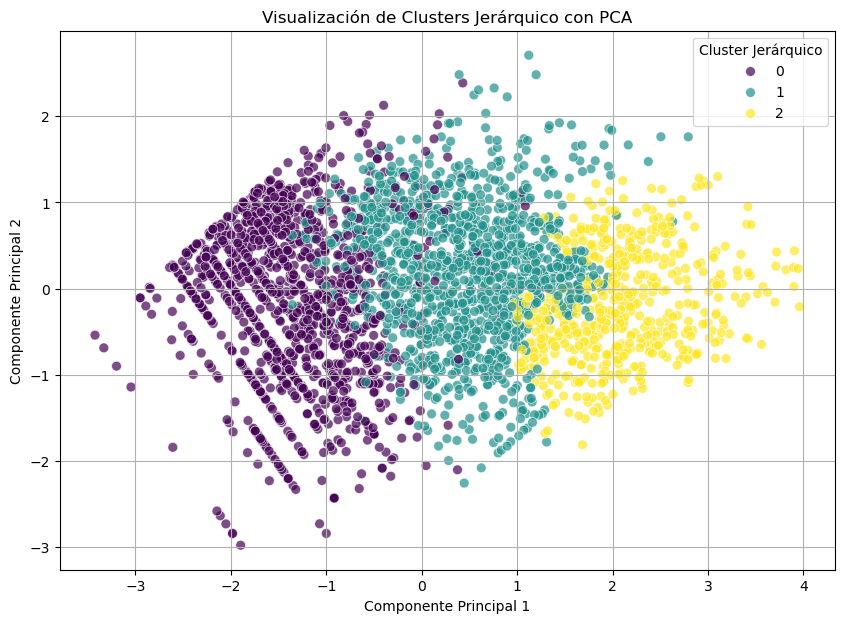

In [698]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x="PC1", y="PC2", hue="agglomerative_cluster", data=rfm_pca_df, palette="viridis", s=50, alpha=0.7)
plt.title("Visualización de Clusters Jerárquico con PCA")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Cluster Jerárquico")
plt.grid(True)
plt.show()

### **KMeans Clustering**

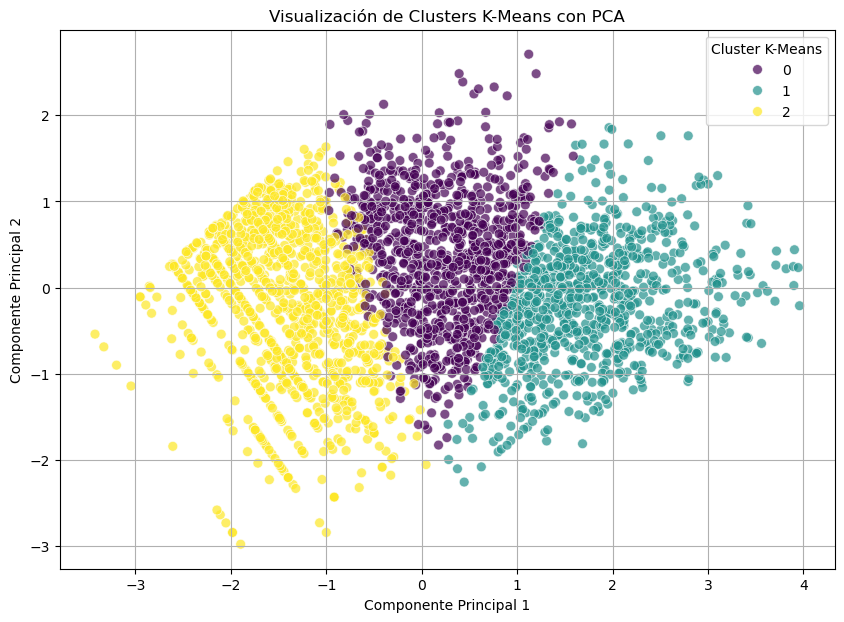

In [699]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x="PC1", y="PC2", hue="kmeans_cluster", data=rfm_pca_df, palette="viridis", s=50, alpha=0.7)
plt.title("Visualización de Clusters K-Means con PCA")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Cluster K-Means")
plt.grid(True)
plt.show()

### **DBSCAN Clustering**

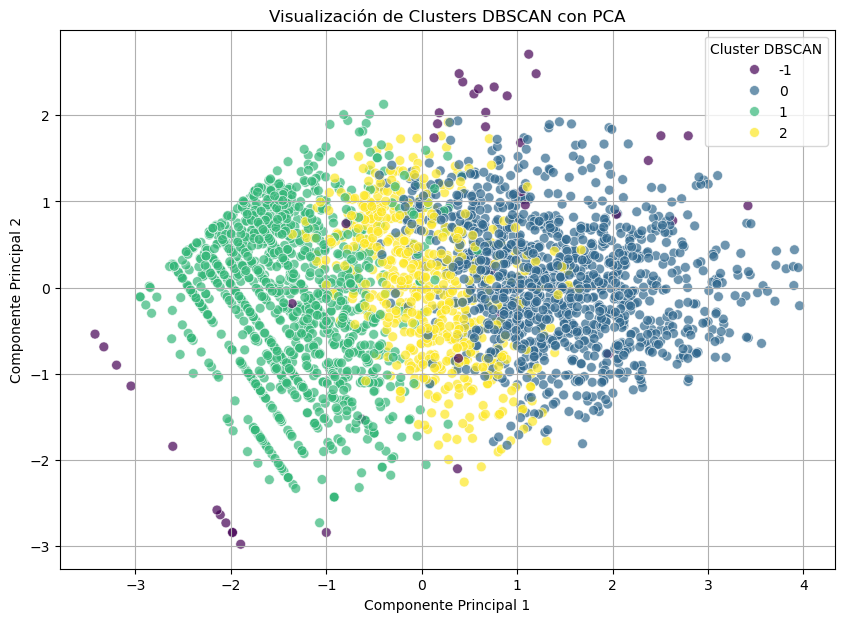

In [700]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x="PC1", y="PC2", hue="dbscan_cluster", data=rfm_pca_df, palette="viridis", s=50, alpha=0.7)
plt.title("Visualización de Clusters DBSCAN con PCA")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Cluster DBSCAN")
plt.grid(True)
plt.show()

In [701]:
dbscan_mask = rfm_df["dbs_cluster"] != -1

scores = {"K-Means": {},"Agglomerative": {},"DBSCAN": {}}

scores["K-Means"]["Silhouette"] = silhouette_score(rfm_scaled, rfm_df["km_cluster"])
scores["Agglomerative"]["Silhouette"] = silhouette_score(rfm_scaled, rfm_df["agg_cluster"])
scores["DBSCAN"]["Silhouette"] = silhouette_score(rfm_scaled[dbscan_mask], rfm_df.loc[dbscan_mask, "dbs_cluster"])

scores["K-Means"]["Davies-Bouldin"] = davies_bouldin_score(rfm_scaled, rfm_df["km_cluster"])
scores["Agglomerative"]["Davies-Bouldin"] = davies_bouldin_score(rfm_scaled, rfm_df["agg_cluster"])
scores["DBSCAN"]["Davies-Bouldin"] = davies_bouldin_score(rfm_scaled[dbscan_mask], rfm_df.loc[dbscan_mask, "dbs_cluster"])

scores["K-Means"]["Calinski-Harabasz"] = calinski_harabasz_score(rfm_scaled, rfm_df["km_cluster"])
scores["Agglomerative"]["Calinski-Harabasz"] = calinski_harabasz_score(rfm_scaled, rfm_df['agg_cluster'])
scores["DBSCAN"]["Calinski-Harabasz"] = calinski_harabasz_score(rfm_scaled[dbscan_mask], rfm_df.loc[dbscan_mask, "dbs_cluster"])

scores_df = pd.DataFrame(scores).T
normalized_scores = pd.DataFrame(index=scores_df.index)
scaler = MinMaxScaler()
normalized_scores["Silhouette_Norm"] = scaler.fit_transform(scores_df[["Silhouette"]]).flatten()
normalized_scores["Calinski_Norm"] = scaler.fit_transform(scores_df[["Calinski-Harabasz"]]).flatten()
normalized_scores["Davies_Bouldin_Norm"] = 1 - scaler.fit_transform(scores_df[["Davies-Bouldin"]]).flatten()
normalized_scores["Puntaje_Compuesto"] = normalized_scores.mean(axis=1)

print("--- Tabla de Evaluación de Modelos de Clustering ---")
final_evaluation = pd.concat([scores_df, normalized_scores], axis=1)
print(final_evaluation.sort_values(by="Puntaje_Compuesto", ascending=False).round(4))

print("\nEl mejor modelo según el Puntaje Compuesto es:", final_evaluation["Puntaje_Compuesto"].idxmax())

--- Tabla de Evaluación de Modelos de Clustering ---
               Silhouette  Davies-Bouldin  Calinski-Harabasz  Silhouette_Norm  \
K-Means            0.3221          1.1591          2327.2369           1.0000   
Agglomerative      0.3050          1.1117          2071.3071           0.7677   
DBSCAN             0.2482          1.4099          1899.9586           0.0000   

               Calinski_Norm  Davies_Bouldin_Norm  Puntaje_Compuesto  
K-Means                1.000               0.8409             0.9470  
Agglomerative          0.401               1.0000             0.7229  
DBSCAN                 0.000               0.0000             0.0000  

El mejor modelo según el Puntaje Compuesto es: K-Means


In [702]:
print("--- Caracterización de Clusters K-Means ---")
km_summary.head()

--- Caracterización de Clusters K-Means ---


,km_cluster,recency,frequency,monetary_value,n_customers
0,0,98.23,2.62,7139.49,964
1,1,17.60,7.07,23139.21,885
2,2,154.21,1.03,78.22,1235


* **Cluster 0 (Clientes en Riesgo):** Este grupo tiene un valor moderado (7,139.49) y una frecuencia de compra decente (2.62), pero no han comprado en bastante tiempo (recencia de 98.23). Requieren atención para evitar que se pierdan.

* **Cluster 1 (Clientes Campeones):** Este es el grupo más valioso. Tienen la recencia más baja (17.60), la frecuencia más alta (7.07) y el valor monetario más alto (23,139.21). Son clientes leales y recientes que gastan mucho.

* **Cluster 2 (Clientes Ocasionales o Perdidos):** Es el grupo más grande (1,235 clientes) pero el menos valioso. Su recencia es muy alta (154.21) y su frecuencia y gasto son mínimos. Probablemente son compradores de una sola vez o clientes inactivos.